In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
# load env variables from .env file
import dotenv
dotenv.load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

model_id = "gpt-4o-2024-08-06"

from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.05,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

llm = ChatOpenAI(
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# graph_builder.add_node("chatbot", chatbot)

In [4]:
graph = graph_builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

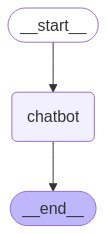

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm **DeepSeek Chat**, an AI assistant created by **DeepSeek**, and here’s what I can do for you:  

### 🔍 **Knowledge & Assistance**  
- Answer questions on diverse topics (science, history, tech, entertainment, etc.).  
- Provide explanations, summaries, and detailed analyses.  
- Offer step-by-step problem-solving for math, coding, and logic puzzles.  

### 📄 **Document Processing**  
- Read and analyze uploaded documents (**PDFs, Word, Excel, PowerPoint, TXT**).  
- Extract key information, summarize content, or answer questions about the document.  

### 📝 **Writing & Editing**  
- Help with essays, reports, emails, and creative writing (stories, poems, scripts).  
- Rewrite, proofread, or refine your text for clarity and style.  

### 💻 **Coding & Tech Support**  
- Write, debug, and optimize code in Python, Java, C++, JavaScript, and more.  
- Explain programming concepts, algorithms, and best practices.  

### 🌍 **Translation & Language Skills**  
- Translate between

In [4]:
from langchain_core.tools import tool
from enum import Enum
from langchain_core.messages import HumanMessage, SystemMessage

class LocationEnum(str, Enum):
    kitchen = "kitchen"
    living_room = "living_room"
    bedroom = "bedroom"

@tool
def go_to_coordinates(x: float, y: float):
    """
    Move the robot to a specific set of coordinates.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If x or y is not a number.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'success', 'message': 'Moved to coordinates (10.5, 20.3)'}
    Example:
        >>> go_to_coordinates("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move to coordinates (10.5, 20.3)'}
    """
    print(f"Moving to coordinates ({x}, {y})")
    # Here you would add the code to move the robot to the specified coordinates
    return {"status": "success", "message": f"Moved to coordinates ({x}, {y})"}

@tool
def go_to_location(location_name: LocationEnum):
    """
    Move the robot to a specific location.
    Args:
        location_name (LocationEnum): The name of the location.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If location_name is not a valid location.
    Example:
        >>> go_to_location("kitchen")
        {'status': 'success', 'message': 'Moved to location: kitchen'}
    Example:
        >>> go_to_location("garage")
        ValueError: location_name must be one of ['kitchen', 'living_room', 'bedroom'].
    Example:
        >>> go_to_location("living_room")
        {'status': 'failure', 'message': 'Failed to move to location: living_room'}
    """
    print(f"Moving to location: {location_name}")
    # Here you would add the code to move the robot to the specified location
    return {"status": "success", "message": f"Moved to location: {location_name}"}

@tool
def rotate(angle: float):
    """
    Rotate the robot to a specific angle.
    Args:
        angle (float): The angle to rotate to.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If angle is not a number.
    Example:
        >>> rotate(90)
        {'status': 'success', 'message': 'Rotated to angle: 90'}
    Example:
        >>> rotate("90")
        ValueError: angle must be a number.
    Example:
        >>> rotate(90)
        {'status': 'failure', 'message': 'Failed to rotate to angle: 90'}
    """
    print(f"Rotating to angle: {angle}")
    # Here you would add the code to rotate the robot to the specified angle
    return {"status": "success", "message": f"Rotated to angle: {angle}"}

@tool
def get_pose():
    """
    Get the current pose of the robot.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> get_pose()
        {'status': 'success', 'message': 'Current pose: (x, y, theta)'}
    Example:
        >>> get_pose()
        {'status': 'failure', 'message': 'Failed to get pose'}
    """
    print("Getting current pose")
    # Here you would add the code to get the current pose of the robot
    return {"status": "success", "message": "Current pose: (x, y, theta)"}

@tool
def follow_person():
    """
    Follow a person.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> follow_person()
        {'status': 'success', 'message': 'Following person'}
    Example:
        >>> follow_person()
        {'status': 'failure', 'message': 'Failed to follow person'}
    """
    print("Following person")
    # Here you would add the code to follow a person
    return {"status": "success", "message": "Following person"}

nav_tools = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]
nav_llm_with_tools = llm.bind_tools(nav_tools)

In [5]:
# Agent system prompts
sub_str = """
                'plan': \[
                            \{'tool': 'tool_name': parameters: \[param1,...,paramN\], 'parallel': True/False \},
                            ...
                        \]
        """
agent_sys_msg = lambda module: f"""You are the {module} head of a Robot, you have access to a set of tools that represent the robot's capabilities and
                        you are tasked with translating a user's natural language command to one of the available tools with the appropriate parameters.
                        Note that you can chain several tools together to fulfill a user command, you can also specify whether to run tools in parallel or sequentially.
                        You have a set of tools at your disposal, each with its own set of parameters, you can call the tools, but you must
                        also provide a concise reasoning for your choice in the tool_messages section for each one of the tool_calls.
                        """

planning_sys_msg = """You are the planning head of a robot that has several capabilities, you have access to several specialized agents,
                        each with its own set of capabilities.
                        You are tasked with finding the best plan to execute on the user's command based on the agents you have at disposal
                        and their capabilities.
                        You can also specify wheter to run commands sequentially or in parallel.
                        Your output should be very precise and concise.
                        The agent names are the following: ["conversation", "manipulation", "navigation", "vision"]
                        Output format:
                        'reasoning': Explain the overarching goal and how you plan to achieve it (be very concise)
                        'plan': \[
                                    \{'agent': 'agent_name', 'command': 'the command to be run by the agent', 'parallel': True/False \},
                                    ...
                                \]
                        """

In [6]:
from langgraph.graph import MessagesState
def navigation_agent(state: MessagesState):
    return {"messages": [nav_llm_with_tools.invoke([agent_sys_msg(module="navigation")] + state["messages"])]}

In [7]:
# Manipulation tools

@tool
def move_arm(x: float, y: float):
    """
    Move the robot's arm to a specific position.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'success', 'message': 'Moved arm to coordinates (10.5, 20.3)'}
    Example:
        >>> move_arm("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move arm to coordinates (10.5, 20.3)'}
    """
    print(f"Moving arm to coordinates ({x}, {y})")
    # Here you would add the code to move the robot's arm to the specified coordinates
    return {"status": "success", "message": f"Moved arm to coordinates ({x}, {y})"}

@tool
def move_joints(joint_angles: list):
    """
    Move the robot's joints to specific angles.
    Args:
        joint_angles (list): A list of joint angles.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'success', 'message': 'Moved joints to angles [30, 45, 60]'}
    Example:
        >>> move_joints("30, 45, 60")
        ValueError: joint_angles must be a list of numbers.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'failure', 'message': 'Failed to move joints to angles [30, 45, 60]'}
    """
    print(f"Moving joints to angles {joint_angles}")
    # Here you would add the code to move the robot's joints to the specified angles
    return {"status": "success", "message": f"Moved joints to angles {joint_angles}"}

@tool
def pick_up_object(object_name: str):
    """
    Pick up an object.
    Args:
        object_name (str): The name of the object to pick up.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> pick_up_object("box")
        {'status': 'success', 'message': 'Picked up object: box'}
    Example:
        >>> pick_up_object(123)
        ValueError: object_name must be a string.
    Example:
        >>> pick_up_object("box")
        {'status': 'failure', 'message': 'Failed to pick up object: box'}
    """
    print(f"Picking up object: {object_name}")
    # Here you would add the code to pick up the specified object
    return {"status": "success", "message": f"Picked up object: {object_name}"}

@tool
def press_button(button_name: str):
    """
    Press a button.
    Args:
        button_name (str): The name of the button to press.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> press_button("start")
        {'status': 'success', 'message': 'Pressed button: start'}
    Example:
        >>> press_button(123)
        ValueError: button_name must be a string.
    Example:
        >>> press_button("start")
        {'status': 'failure', 'message': 'Failed to press button: start'}
    """
    print(f"Pressing button: {button_name}")
    # Here you would add the code to press the specified button
    return {"status": "success", "message": f"Pressed button: {button_name}"}

manip_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

manip_tools = [
    move_arm,
    move_joints,
    pick_up_object
]
nav_tools = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]
manip_llm_with_tools = manip_llm.bind_tools(manip_tools)
def manipulation_agent(state: MessagesState):
    return {"messages": [manip_llm_with_tools.invoke([agent_sys_msg(module="navigation")] + state["messages"])]}

In [8]:
from typing import Optional, List

In [ ]:


vision_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

vision_tools = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]
manip_tools = [
    move_arm,
    move_joints,
    pick_up_object
]
nav_tools = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]

vision_llm_with_tools = vision_llm.bind_tools(vision_tools)
def vision_agent(state: MessagesState):
    return {"messages": [vision_llm_with_tools.invoke([agent_sys_msg(module="vision")] + state["messages"])]}

In [ ]:
# Conversational tools
@tool
def clarify(context: str, question: str):
    """
    Clarify a question based on the context.
    Args:
        context (str): The context to clarify the question.
        question (str): The question to clarify.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'success', 'message': 'The robot is in the kitchen.'}
    Example:
        >>> clarify("The robot is in the kitchen.", 123)
        ValueError: question must be a string.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'failure', 'message': 'Failed to clarify the question.'}
    """
    print(f"Clarifying question: {question} based on context: {context}")
    # Here you would add the code to clarify the question based on the context
    return {"status": "success", "message": f"The robot is in the kitchen."}

@tool
def speak(text: str):
    """
    Speak a given text.
    Args:
        text (str): The text to speak.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> speak("Hello, world!")
        {'status': 'success', 'message': 'Spoken text: Hello, world!'}
    Example:
        >>> speak(123)
        ValueError: text must be a string.
    Example:
        >>> speak("Hello, world!")
        {'status': 'failure', 'message': 'Failed to speak text: Hello, world!'}
    """
    print(f"Speaking text: {text}")
    # Here you would add the code to speak the given text
    return {"status": "success", "message": f"Spoken text: {text}"}

conv_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

conv_tools = [
    clarify,
    speak
]
vision_tools = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]
manip_tools = [
    move_arm,
    move_joints,
    pick_up_object
]
nav_tools = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]
conv_llm_with_tools = conv_llm.bind_tools(conv_tools)
def conv_agent(state: MessagesState):
    return {"messages": [conv_llm_with_tools.invoke([agent_sys_msg(module="conversation")] + state["messages"])]}

NameError: name 'take_picture' is not defined

In [10]:
planning_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=1000
    )

def planning_agent(state: MessagesState):
    return {"messages": [planning_llm.invoke([planning_sys_msg] + state["messages"])]}

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from ast import literal_eval
import json
import re

# Graph
builder = StateGraph(State)

# Add the nodes to the graph
builder.add_node("planning", planning_agent)
builder.add_node("conversation", conv_agent)
builder.add_node("manipulation", manipulation_agent)
builder.add_node("navigation", navigation_agent)
builder.add_node("vision", vision_agent)

# Define the edges of the graph
builder.add_edge(START, "planning")

# Define a condition function to route messages based on the planning agent's decision
def route_to_agent(state):
    # Get the last message from the assistant (which should be from the planning agent)
    last_message = state["messages"][-1]
    
    if "plan" not in last_message.content:
        return END
    
    # Try to extract the plan from the message content
    # Use regex to extract JSON structure
    pattern = r'\[.*?\]'
    match = re.search(pattern, last_message.content, re.DOTALL)
    
    if match:
        try:
            plan_data = literal_eval(match.group().replace("\\{", "{").replace("\\}", "}").replace("\[", "[").replace("\]", "]").replace("\\'", "'"))
            if len(plan_data) > 0:
                # Get the first agent in the plan
                next_step = plan_data[0]
                next_agent = next_step["agent"]
                
                # Update the original state with the modified plan (for future steps)
                if plan_data:
                    last_message.content = json.dumps(plan_data)
                
                # Return the next agent to call along with the new state
                if next_agent in ["conversation", "manipulation", "navigation", "vision"]:
                    return next_agent
        except json.JSONDecodeError:
            pass

    print("No valid plan found or unable to parse the plan.")
    
    return END

# Add conditional edges from planning to other agents
builder.add_conditional_edges(
    "planning",
    route_to_agent,
    {
        "conversation": "conversation",
        "manipulation": "manipulation",
        "navigation": "navigation",
        "vision": "vision",
        END: END
    }
)

# Add edges from other agents back to planning or to END
# builder.add_edge("conversation", "planning")
# builder.add_edge("manipulation", "planning")
# builder.add_edge("navigation", "planning")
# builder.add_edge("vision", "planning")

builder.add_edge(["conversation", "manipulation", "navigation", "vision"], END)

# Compile the graph
react_graph = builder.compile()


NameError: name 'conv_agent' is not defined

In [13]:
messages = [HumanMessage(content="Can you pick up the banana?")]

for chunk in react_graph.stream({"messages": messages}, stream_mode="messages", debug=True):
    pass

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={}, id='0d152d9d-8207-489a-bf56-52df34d49116')]}
[1:tasks] Starting 1 task for step 1:
- planning -> {'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={}, id='0d152d9d-8207-489a-bf56-52df34d49116')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='[{"agent": "vision", "command": "locate the banana", "parallel": false}, {"agent": "manipulation", "command": "pick 

In [18]:
# pip install -U langgraph langchain_openai pydantic
from __future__ import annotations
from typing import List, Dict, Literal, TypedDict, Any
import json, re, os
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.graph import (
    StateGraph, MessagesState, START, END
)
from langgraph.types import Command
from langgraph.prebuilt import ToolNode

# ---------------------------------------------------------------------------
# 1.  Shared graph-state
# ---------------------------------------------------------------------------

class PlanState(MessagesState):                 # <- inherits "messages"
    plan: List[Dict[str, Any]] = None             # remaining steps
    current: Dict[str, Any] | None = None       # step being executed

# ---------------------------------------------------------------------------
# 2.  The planning agent (supervisor)
# ---------------------------------------------------------------------------

planner_llm = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0.1)

PLAN_JSON_RE = re.compile(r"\[.*\]", re.DOTALL)

def _extract_plan(text: str) -> List[Dict[str, Any]]:
    """Robustly pull the JSON list out of the LLM reply."""
    m = PLAN_JSON_RE.search(text)
    if not m:
        raise ValueError("Planner returned no JSON plan")
    return json.loads(m.group())

def planning_node(state: PlanState | dict) -> Command[Literal[
        "vision", "navigation", "manipulation", "conversation", END]]:
    """
    * If we already have a remaining plan, just pop the next step.
    * Otherwise ask the planner LLM to create a fresh plan.
    """
    print(f"State: {state}")
    if type(state) == dict or state.plan is None:
        user_prompt = state.messages[-1]              # last human message
        raw_reply   = planner_llm.invoke(user_prompt)
        plan        = _extract_plan(raw_reply.content)
        state.update(messages=[raw_reply], plan=plan)

    # pop next step
    next_step = state.plan.pop(0)
    state.current = next_step
    next_agent = next_step["agent"]

    # when the list is empty after pop -> finish execution
    return Command(
        goto=next_agent if state.plan or next_agent else END,
        update={"plan": state.plan, "current": state.current}
    )

# ---------------------------------------------------------------------------
# 3.  Tool definitions for each specialist
# ---------------------------------------------------------------------------
CONV_TOOLS = [
    clarify,
    speak
]
VISION_TOOLS = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]
MANIPULATION_TOOLS = [
    move_arm,
    move_joints,
    pick_up_object
]
NAVIGATION_TOOLS = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]

def _make_agent(name: str, tools):
    """Returns (tool_calling_LLM, tool_node) for a specialist."""
    if not tools:                              # pure-LLM specialist
        return ChatOpenAI(model="gpt-4o-mini", temperature=0), None

    model    = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)
    toolnode = ToolNode(tools)
    return model, toolnode

specs = {
    "vision":        _make_agent("vision",        VISION_TOOLS),
    "navigation":    _make_agent("navigation",    NAVIGATION_TOOLS),
    "manipulation":  _make_agent("manipulation",  MANIPULATION_TOOLS),
    "conversation":  _make_agent("conversation",  CONV_TOOLS),
}

# ---------------------------------------------------------------------------
# 4.  Generic specialist node factory
# ---------------------------------------------------------------------------

def specialist_factory(agent_name: str):
    llm, tool_node = specs[agent_name]

    def _node(state: PlanState) -> Command[Literal["planning"]]:
        """Run the specialist on state.current['command']."""
        cmd = state.current["command"]
        # 1) Ask the LLM how it wants to fulfil the command
        
        ai_msg: AIMessage = llm.invoke(agent_sys_msg(module=agent_name) + cmd)
        new_messages = [ai_msg]

        # 2) If the LLM requested tool(s) -> run them
        if ai_msg.tool_calls and tool_node is not None:
            tool_out = tool_node.invoke({"messages": [ai_msg]})
            new_messages.extend(tool_out["messages"])

        # 3) Update transcript and hand control back to planner
        return Command(
            goto="planning",
            update={"messages": new_messages}
        )

    return _node

# ---------------------------------------------------------------------------
# 5.  Build the graph
# ---------------------------------------------------------------------------

builder = StateGraph(PlanState)

# nodes
builder.add_node("planning", planning_node)
for name in ["vision", "navigation", "manipulation", "conversation"]:
    builder.add_node(name, specialist_factory(name))

# start / end edges – everything else is handled by Command-based gotos
builder.add_edge(START, "planning")

graph = builder.compile()


In [19]:
# ---------------------------------------------------------------------------
# 6.  A quick demo run
# ---------------------------------------------------------------------------

example_question = [
    ("human", "Please find the banana, drive to it and tell me once you arrive.")
]

for s in graph.stream({"messages": example_question}, stream_mode="values", debug=True):
    # pretty print the last message for demo purposes
    s["messages"][-1].pretty_print()

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('human',
               'Please find the banana, drive to it and tell me once you '
               'arrive.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('human', 'Please find the banana, drive to it and tell me once you arrive.')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Please find the banana, drive to it and tell me once you arrive.', additional_kwargs={}, response_metadata={}, id='c9eecb86-9d28-4111-bda3-0d6a71f9de19')]}
[1:tasks] Starting 1 task for step 1:
- planning -> {'messages': [HumanMessage(content='Please find the banana, drive to it and tell me once you arrive.', additional_kwargs={}, response_metadata={}, id='c9eecb86-9d28-4111-bda3-0d6a71f9de19')]}
================================ Human Message =================================

Please find the banana, drive to it and tell me on

AttributeError: 'dict' object has no attribute 'messages'

In [ ]:
messages = [HumanMessage(content="Can you pick up the banana?")]

for chunk in react_graph.stream({"messages": messages}, stream_mode="messages", debug=True):
    pass

***

In [1]:
"""
agents_graph.py
-----------------------------------------------------------------
A LangGraph that orchestrates a Planner + 4 specialised agents
(Vision, Navigation, Manipulation, Conversation).

• The planner (system‑prompted) receives the user request first and
  emits a JSON list like
     [{"agent": "vision", "command": "...", "parallel": false}, …]

• Each specialist is an LLM able to call its own tools.
  – On **success** the tool result is appended to state.results.
  – On **failure** the specialist bounces straight back to the
    planner, giving it a chance to re‑plan.

• When the last step in the plan succeeds, the whole accumulated
  results array is handed to the planner so it can produce the
  final answer for the user.

Requires:  langgraph ≥ 0.1  |  langchain_openai  |  python ≥ 3.9
-----------------------------------------------------------------
"""
from __future__ import annotations
from typing import List, Dict, Literal, Any
import os, json, re, asyncio
from dataclasses import dataclass, field

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.graph import (
    StateGraph, START, END, MessagesState
)
from langgraph.prebuilt import ToolNode
from langgraph.types import Command

In [2]:
# ---------------------------------------------------------------------
# 0.  SYSTEM PROMPTS
# ---------------------------------------------------------------------

PLANNER_PROMPT = """\
You are the **planner**.  
Given the user's request, break the task into a minimal
sequence of specialised agents.  Return **only** a JSON list,
e.g.
[
  {"agent": "vision", "command": "locate the banana", "parallel": false},
  {"agent": "navigation", "command": "drive to (x=42,y=7)", "parallel": false}
]
"""

VISION_PROMPT = "You are the **Vision** agent. Use your vision tools only."
NAV_PROMPT    = "You are the **Navigation** agent. Drive the robot."
MANIP_PROMPT  = "You are the **Manipulation** agent. Move robot arms."
CONV_PROMPT   = "You are the **Conversation** agent. Talk to the user."

In [19]:
# 1.  SHARED GRAPH‑STATE
# ---------------------------------------------------------------------
from typing import TypedDict, List, Dict, Any, Optional

class PlanState(MessagesState, total=False):
    plan:    List[Dict[str, Any]] = field(default_factory=list)
    current: Optional[Dict[str, Any]] = None
    results: List[str] = field(default_factory=list)

In [30]:
# 2.  THE PLANNER NODE
# ---------------------------------------------------------------------

planner_llm = ChatOpenAI(
    model       = "gpt-4o-mini",
    temperature = 0,
    streaming   = False
).with_config({"system_prompt": PLANNER_PROMPT})

_JSON_RE = re.compile(r"\[[\s\S]*\]")      # grab first JSON list

def parse_plan(text: str) -> List[Dict[str, Any]]:
    m = _JSON_RE.search(text)
    if not m:
        raise ValueError("Planner returned no JSON list")
    return json.loads(m.group())

def planner_node(state: PlanState) -> Command[
        Literal["vision","navigation","manipulation","conversation",END]]:
    """
    • If state.plan is empty, ask LLM for a new one.
    • Otherwise we have just finished all steps and must craft the
      final answer.
    """
    # —— 1) Need a new plan? ————————————————————————————————
    if type(state) == dict or not state.plan:
        # ask planner LLM (user message is always last)
        reply: AIMessage = planner_llm.invoke(state.messages[-1])
        plan = parse_plan(reply.content)

        state.update(messages=[reply], plan=plan, results=[])

        # pop first step
        step = state.plan.pop(0)
        state.current = step
        return Command(
            goto = step["agent"],
            update = {
                "plan": state.plan,
                "current": step,
            },
        )

    # —— 2) We have just completed **all** steps ————————————————
    # Build a synthetic summary message and finish.
    summary = "\n".join(state.results)
    final_msg = AIMessage(content=f"All tools executed successfully:\n{summary}")
    return Command(
        goto   = END,
        update = {"messages": [final_msg]}
    )

In [12]:
# 3.  TOOLS
# ---------------------------------------------------------------------
from enum import Enum

class LocationEnum(str, Enum):
    kitchen = "kitchen"
    living_room = "living_room"
    bedroom = "bedroom"

# Navigation tools
@tool
def go_to_coordinates(x: float, y: float):
    """
    Move the robot to a specific set of coordinates.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If x or y is not a number.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'success', 'message': 'Moved to coordinates (10.5, 20.3)'}
    Example:
        >>> go_to_coordinates("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move to coordinates (10.5, 20.3)'}
    """
    print(f"Moving to coordinates ({x}, {y})")
    # Here you would add the code to move the robot to the specified coordinates
    return {"status": "success", "message": f"Moved to coordinates ({x}, {y})"}

@tool
def go_to_location(location_name: LocationEnum):
    """
    Move the robot to a specific location.
    Args:
        location_name (LocationEnum): The name of the location.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If location_name is not a valid location.
    Example:
        >>> go_to_location("kitchen")
        {'status': 'success', 'message': 'Moved to location: kitchen'}
    Example:
        >>> go_to_location("garage")
        ValueError: location_name must be one of ['kitchen', 'living_room', 'bedroom'].
    Example:
        >>> go_to_location("living_room")
        {'status': 'failure', 'message': 'Failed to move to location: living_room'}
    """
    print(f"Moving to location: {location_name}")
    # Here you would add the code to move the robot to the specified location
    return {"status": "success", "message": f"Moved to location: {location_name}"}

@tool
def rotate(angle: float):
    """
    Rotate the robot to a specific angle.
    Args:
        angle (float): The angle to rotate to.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If angle is not a number.
    Example:
        >>> rotate(90)
        {'status': 'success', 'message': 'Rotated to angle: 90'}
    Example:
        >>> rotate("90")
        ValueError: angle must be a number.
    Example:
        >>> rotate(90)
        {'status': 'failure', 'message': 'Failed to rotate to angle: 90'}
    """
    print(f"Rotating to angle: {angle}")
    # Here you would add the code to rotate the robot to the specified angle
    return {"status": "success", "message": f"Rotated to angle: {angle}"}

@tool
def get_pose():
    """
    Get the current pose of the robot.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> get_pose()
        {'status': 'success', 'message': 'Current pose: (x, y, theta)'}
    Example:
        >>> get_pose()
        {'status': 'failure', 'message': 'Failed to get pose'}
    """
    print("Getting current pose")
    # Here you would add the code to get the current pose of the robot
    return {"status": "success", "message": "Current pose: (x, y, theta)"}

@tool
def follow_person():
    """
    Follow a person.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> follow_person()
        {'status': 'success', 'message': 'Following person'}
    Example:
        >>> follow_person()
        {'status': 'failure', 'message': 'Failed to follow person'}
    """
    print("Following person")
    # Here you would add the code to follow a person
    return {"status": "success", "message": "Following person"}

# Manipulation tools
@tool
def move_arm(x: float, y: float):
    """
    Move the robot's arm to a specific position.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'success', 'message': 'Moved arm to coordinates (10.5, 20.3)'}
    Example:
        >>> move_arm("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move arm to coordinates (10.5, 20.3)'}
    """
    print(f"Moving arm to coordinates ({x}, {y})")
    # Here you would add the code to move the robot's arm to the specified coordinates
    return {"status": "success", "message": f"Moved arm to coordinates ({x}, {y})"}

@tool
def move_joints(joint_angles: list):
    """
    Move the robot's joints to specific angles.
    Args:
        joint_angles (list): A list of joint angles.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'success', 'message': 'Moved joints to angles [30, 45, 60]'}
    Example:
        >>> move_joints("30, 45, 60")
        ValueError: joint_angles must be a list of numbers.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'failure', 'message': 'Failed to move joints to angles [30, 45, 60]'}
    """
    print(f"Moving joints to angles {joint_angles}")
    # Here you would add the code to move the robot's joints to the specified angles
    return {"status": "success", "message": f"Moved joints to angles {joint_angles}"}

@tool
def pick_up_object(object_name: str):
    """
    Pick up an object.
    Args:
        object_name (str): The name of the object to pick up.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> pick_up_object("box")
        {'status': 'success', 'message': 'Picked up object: box'}
    Example:
        >>> pick_up_object(123)
        ValueError: object_name must be a string.
    Example:
        >>> pick_up_object("box")
        {'status': 'failure', 'message': 'Failed to pick up object: box'}
    """
    print(f"Picking up object: {object_name}")
    # Here you would add the code to pick up the specified object
    return {"status": "success", "message": f"Picked up object: {object_name}"}

@tool
def press_button(button_name: str):
    """
    Press a button.
    Args:
        button_name (str): The name of the button to press.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> press_button("start")
        {'status': 'success', 'message': 'Pressed button: start'}
    Example:
        >>> press_button(123)
        ValueError: button_name must be a string.
    Example:
        >>> press_button("start")
        {'status': 'failure', 'message': 'Failed to press button: start'}
    """
    print(f"Pressing button: {button_name}")
    # Here you would add the code to press the specified button
    return {"status": "success", "message": f"Pressed button: {button_name}"}

# Vision tools
@tool
def take_picture():
    """
    Take a picture.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> take_picture()
        {'status': 'success', 'message': 'Picture taken'}
    Example:
        >>> take_picture()
        {'status': 'failure', 'message': 'Failed to take picture'}
    """
    print("Taking picture")
    # Here you would add the code to take a picture
    return {"status": "success", "message": "Picture taken"}

@tool
def detect_objects(objects: List[str]):
    """
    Detect objects in the environment.
    Args:
        objects (List[str]): A list of object names to detect.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'success', 'message': 'Detected objects: box, chair'}
    Example:
        >>> detect_objects("box, chair")
        ValueError: objects must be a list of strings.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'failure', 'message': 'Failed to detect objects: box, chair'}
    """
    print(f"Detecting objects: {objects}")
    # Here you would add the code to detect the specified objects
    return {"status": "success", "message": f"Detected objects: {', '.join(objects)}"}

@tool
def recognize_text():
    """
    Recognize text in the environment.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> recognize_text()
        {'status': 'success', 'message': 'Recognized text: Hello, world!'}
    Example:
        >>> recognize_text()
        {'status': 'failure', 'message': 'Failed to recognize text'}
    """
    print("Recognizing text")
    # Here you would add the code to recognize text
    return {"status": "success", "message": "Recognized text: Hello, world!"}

@tool
def semantic_segmentation():
    """
    Perform semantic segmentation.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> semantic_segmentation()
        {'status': 'success', 'message': 'Semantic segmentation completed'}
    Example:
        >>> semantic_segmentation()
        {'status': 'failure', 'message': 'Failed to perform semantic segmentation'}
    """
    print("Performing semantic segmentation")
    # Here you would add the code to perform semantic segmentation
    return {"status": "success", "message": "Semantic segmentation completed"}

# Conversational tools
@tool
def clarify(context: str, question: str):
    """
    Clarify a question based on the context.
    Args:
        context (str): The context to clarify the question.
        question (str): The question to clarify.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'success', 'message': 'The robot is in the kitchen.'}
    Example:
        >>> clarify("The robot is in the kitchen.", 123)
        ValueError: question must be a string.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'failure', 'message': 'Failed to clarify the question.'}
    """
    print(f"Clarifying question: {question} based on context: {context}")
    # Here you would add the code to clarify the question based on the context
    return {"status": "success", "message": f"The robot is in the kitchen."}

@tool
def speak(text: str):
    """
    Speak a given text.
    Args:
        text (str): The text to speak.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> speak("Hello, world!")
        {'status': 'success', 'message': 'Spoken text: Hello, world!'}
    Example:
        >>> speak(123)
        ValueError: text must be a string.
    Example:
        >>> speak("Hello, world!")
        {'status': 'failure', 'message': 'Failed to speak text: Hello, world!'}
    """
    print(f"Speaking text: {text}")
    # Here you would add the code to speak the given text
    return {"status": "success", "message": f"Spoken text: {text}"}



CONV_TOOLS = [
    clarify,
    speak
]
VISION_TOOLS = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]
MANIPULATION_TOOLS = [
    move_arm,
    move_joints,
    pick_up_object
]
NAVIGATION_TOOLS = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]

In [13]:
# ---------------------------------------------------------------------
# 4.  SPECIALIST BUILD HELPER
# ---------------------------------------------------------------------

def make_specialist(
        name: str,
        system_prompt: str,
        tools: list
    ):
    """
    Returns a node function that:
      • gets state.current["command"]
      • lets LLM decide which tool to call
      • executes tool(s) via ToolNode
      • on success → store result, continue to next step or planner
      • on failure → go straight to planner
    """
    base_llm = ChatOpenAI(model="gpt-4o-mini",
                          temperature=0).with_config(
                          {"system_prompt": system_prompt})
    if tools:
        llm = base_llm.bind_tools(tools)
        tool_node = ToolNode(tools)
    else:                   # conversation agent with no tools
        llm, tool_node = base_llm, None

    async def _node(state: PlanState) -> Command[
            Literal["vision","navigation","manipulation","conversation","planning"]]:

        step_cmd = state.current["command"]
        ai_msg: AIMessage = llm.invoke(step_cmd)
        new_msgs = [ai_msg]

        # —— try to run requested tools ————————————————
        success, tool_output = False, ""
        if ai_msg.tool_calls and tool_node:
            try:
                out = tool_node.invoke({"messages": [ai_msg]})
                new_msgs.extend(out["messages"])
                tool_output = out["messages"][-1].content
                success = tool_output and "failed" not in tool_output.lower()
            except Exception as e:
                tool_output = f"Tool error: {e}"

        # —— decide next hop ————————————————————————————————
        if not success:        # immediate feedback to planner
            fail_msg = AIMessage(content=f"{name} failed: {tool_output}")
            return Command(
                goto   = "planning",
                update = {"messages": new_msgs + [fail_msg]}
            )

        # success → append result
        state.results.append(f"{name}: {tool_output}")

        if state.plan:        # still steps left → next agent
            nxt = state.plan.pop(0)
            state.current = nxt
            return Command(
                goto   = nxt["agent"],
                update = {
                    "plan": state.plan,
                    "current": nxt,
                    "messages": new_msgs
                }
            )

        # last step finished → back to planner with results
        return Command(
            goto   = "planning",
            update = {"messages": new_msgs}
        )

    return _node

In [14]:
# ---------------------------------------------------------------------
# 5.  BUILD GRAPH
# ---------------------------------------------------------------------

builder = StateGraph(PlanState)

builder.add_node("planning",       planner_node)
builder.add_node("vision",         make_specialist("vision",        VISION_PROMPT, VISION_TOOLS))
builder.add_node("navigation",     make_specialist("navigation",    NAV_PROMPT,    NAVIGATION_TOOLS))
builder.add_node("manipulation",   make_specialist("manipulation",  MANIP_PROMPT,  MANIPULATION_TOOLS))
builder.add_node("conversation",   make_specialist("conversation",  CONV_PROMPT,   CONV_TOOLS))

builder.add_edge(START, "planning")           # entry point
graph = builder.compile()

# show graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

NameError: name 'PlanState' is not defined

In [34]:


# ---------------------------------------------------------------------
# 6.  QUICK DEMO
# ---------------------------------------------------------------------

if __name__ == "__main__":

    print("\n### DEMO – Ask the graph something ###\n")
    user_message = ("human",
        "Find the banana, drive the robot to it and pick it up.")
    stream = graph.stream({"messages": [user_message]}, stream_mode="values")

    for st in stream:
        # print the last message to show progress
        print("—", st["messages"][-1].content)

    print("\n### DONE ###")



### DEMO – Ask the graph something ###

— Find the banana, drive the robot to it and pick it up.


AttributeError: 'dict' object has no attribute 'messages'

In [1]:
"""
agents_graph_simple.py
─────────────────────────────────────────────────────────────────
Hub‑and‑spoke agent graph for controlling a robot.
Planner (hub) decides the next specialist (spoke) step.
Specialists never talk to each other—only to the planner.
This is a trimmed‑down, self‑contained version of your original
script that compiles and keeps the same behaviour.
"""
from __future__ import annotations

import json, re
from dataclasses import dataclass, field
from typing import List, Dict, Any, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

In [2]:
# 1. SYSTEM PROMPTS
# ────────────────────────────────────────────────────────────────
PLANNER_PROMPT = """You are the PLANNER in charge of orchestrating a robot with four
specialists: vision, navigation, manipulation and conversation.
Figure out a short ordered python list of steps (JSON only!) that the robot
must execute to complete the user request.
Return ONLY a python array
Example:
[
  {"agent": "vision",       "command": "locate the banana",          "parallel": false},
  {"agent": "navigation",   "command": "drive to 42 7",               "parallel": false},
  {"agent": "manipulation", "command": "pick up the banana",           "parallel": false},
  {"agent": "conversation", "command": "tell the user the job is done","parallel": false}
]

Remember to output a python list, otherwise the robot won't understand it.
"""

VISION_PROMPT = "You are the VISION specialist. Use vision tools only to locate objects."
NAV_PROMPT    = "You are the NAVIGATION specialist. Drive the robot accurately."
MANIP_PROMPT  = "You are the MANIPULATION specialist. Pick up or drop items."
CONV_PROMPT   = "You are the CONVERSATION specialist. Speak with the human only."

In [34]:
# 2. SHARED GRAPH STATE
# ────────────────────────────────────────────────────────────────
@dataclass
class AgentState:
    """Everything nodes need to know is in here."""
    messages: List[Any] = field(default_factory=list)          # full chat history
    plan:     List[Dict[str, Any]] = field(default_factory=list)  # remaining steps
    current:  Dict[str, Any] | None = None                     # step in progress
    results:  List[str] = field(default_factory=list)          # human‑friendly log
    n_executed: int = 0                                         # number of steps executed

In [22]:
print((not [] and type([]) != list))

False


In [45]:
# 3.  THE PLANNER NODE
# ────────────────────────────────────────────────────────────────
planner_llm = ChatOpenAI(model="gpt-4o", temperature=0.1
                         ).with_config({"system_prompt": PLANNER_PROMPT})
# planner_llm = planner_llm.bind(response_format={"type": "json_object"})

_JSON_RE = re.compile(r"\[[\s\S]*]")

def _parse_plan(text: str) -> List[Dict[str, Any]]:
    m = _JSON_RE.search(text)
    if not m:
        raise ValueError("Planner produced no JSON list")
    return json.loads(m.group())

def planner_node(state: AgentState) -> Command[
        Literal["vision", "navigation", "manipulation", "conversation", END]]:
    """Create a plan if needed, otherwise dispatch next step or finish."""
    updates: Dict[str, Any] = {}

    # Need a plan? — ask the planner LLM
    if not state.plan and state.n_executed == 0:
        llm_reply: AIMessage = planner_llm.invoke([PLANNER_PROMPT] + [state.messages[-1]])
        print(f"llm reply: {llm_reply.content}")
        plan = _parse_plan(llm_reply.content)
        updates["plan"]     = plan
        updates["messages"] = state.messages + [llm_reply]

    # Still have steps? — send the next one to its specialist
    plan = updates.get("plan", state.plan)
    if plan:
        step = plan.pop(0)
        updates.update({"plan": plan, "current": step})
        print(f"executing next step: {step}")
        return Command(goto=step["agent"], update=updates)
    else:
        print(f"No more steps in the plan.")

    # Nothing left — summarise & END
    summary = "\n".join(state.results) or "Nothing executed."
    final_msg = AIMessage(content=f"Here is what happened:\n{summary}")
    updates["messages"] = state.messages + [final_msg]
    return Command(goto=END, update=updates)

In [46]:
# 4.  VERY SMALL DEMO TOOLS
# ────────────────────────────────────────────────────────────────
from enum import Enum

class LocationEnum(str, Enum):
    kitchen = "kitchen"
    living_room = "living_room"
    bedroom = "bedroom"

# Navigation tools
@tool
def go_to_coordinates(x: float, y: float):
    """
    Move the robot to a specific set of coordinates.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If x or y is not a number.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'success', 'message': 'Moved to coordinates (10.5, 20.3)'}
    Example:
        >>> go_to_coordinates("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move to coordinates (10.5, 20.3)'}
    """
    print(f"Moving to coordinates ({x}, {y})")
    # Here you would add the code to move the robot to the specified coordinates
    return {"status": "success", "message": f"Moved to coordinates ({x}, {y})"}

@tool
def go_to_location(location_name: LocationEnum):
    """
    Move the robot to a specific location.
    Args:
        location_name (LocationEnum): The name of the location.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If location_name is not a valid location.
    Example:
        >>> go_to_location("kitchen")
        {'status': 'success', 'message': 'Moved to location: kitchen'}
    Example:
        >>> go_to_location("garage")
        ValueError: location_name must be one of ['kitchen', 'living_room', 'bedroom'].
    Example:
        >>> go_to_location("living_room")
        {'status': 'failure', 'message': 'Failed to move to location: living_room'}
    """
    # Here you would add the code to move the robot to the specified location
    return {"status": "success", "message": f"Moved to location: {location_name}"}

@tool
def rotate(angle: float):
    """
    Rotate the robot to a specific angle.
    Args:
        angle (float): The angle to rotate to.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If angle is not a number.
    Example:
        >>> rotate(90)
        {'status': 'success', 'message': 'Rotated to angle: 90'}
    Example:
        >>> rotate("90")
        ValueError: angle must be a number.
    Example:
        >>> rotate(90)
        {'status': 'failure', 'message': 'Failed to rotate to angle: 90'}
    """
    print(f"Rotating to angle: {angle}")
    # Here you would add the code to rotate the robot to the specified angle
    return {"status": "success", "message": f"Rotated to angle: {angle}"}

@tool
def get_pose():
    """
    Get the current pose of the robot.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> get_pose()
        {'status': 'success', 'message': 'Current pose: (x, y, theta)'}
    Example:
        >>> get_pose()
        {'status': 'failure', 'message': 'Failed to get pose'}
    """
    print("Getting current pose")
    # Here you would add the code to get the current pose of the robot
    return {"status": "success", "message": "Current pose: (x, y, theta)"}

@tool
def follow_person():
    """
    Follow a person.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> follow_person()
        {'status': 'success', 'message': 'Following person'}
    Example:
        >>> follow_person()
        {'status': 'failure', 'message': 'Failed to follow person'}
    """
    print("Following person")
    # Here you would add the code to follow a person
    return {"status": "success", "message": "Following person"}

# Manipulation tools
@tool
def move_arm(x: float, y: float):
    """
    Move the robot's arm to a specific position.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'success', 'message': 'Moved arm to coordinates (10.5, 20.3)'}
    Example:
        >>> move_arm("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move arm to coordinates (10.5, 20.3)'}
    """
    print(f"Moving arm to coordinates ({x}, {y})")
    # Here you would add the code to move the robot's arm to the specified coordinates
    return {"status": "success", "message": f"Moved arm to coordinates ({x}, {y})"}

@tool
def move_joints(joint_angles: list):
    """
    Move the robot's joints to specific angles.
    Args:
        joint_angles (list): A list of joint angles.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'success', 'message': 'Moved joints to angles [30, 45, 60]'}
    Example:
        >>> move_joints("30, 45, 60")
        ValueError: joint_angles must be a list of numbers.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'failure', 'message': 'Failed to move joints to angles [30, 45, 60]'}
    """
    print(f"Moving joints to angles {joint_angles}")
    # Here you would add the code to move the robot's joints to the specified angles
    return {"status": "success", "message": f"Moved joints to angles {joint_angles}"}

@tool
def pick_up_object(object_name: str):
    """
    Pick up an object.
    Args:
        object_name (str): The name of the object to pick up.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> pick_up_object("box")
        {'status': 'success', 'message': 'Picked up object: box'}
    Example:
        >>> pick_up_object(123)
        ValueError: object_name must be a string.
    Example:
        >>> pick_up_object("box")
        {'status': 'failure', 'message': 'Failed to pick up object: box'}
    """
    print(f"Picking up object: {object_name}")
    # Here you would add the code to pick up the specified object
    return {"status": "success", "message": f"Picked up object: {object_name}"}

@tool
def press_button(button_name: str):
    """
    Press a button.
    Args:
        button_name (str): The name of the button to press.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> press_button("start")
        {'status': 'success', 'message': 'Pressed button: start'}
    Example:
        >>> press_button(123)
        ValueError: button_name must be a string.
    Example:
        >>> press_button("start")
        {'status': 'failure', 'message': 'Failed to press button: start'}
    """
    print(f"Pressing button: {button_name}")
    # Here you would add the code to press the specified button
    return {"status": "success", "message": f"Pressed button: {button_name}"}

# Vision tools
@tool
def take_picture():
    """
    Take a picture.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> take_picture()
        {'status': 'success', 'message': 'Picture taken'}
    Example:
        >>> take_picture()
        {'status': 'failure', 'message': 'Failed to take picture'}
    """
    print("Taking picture")
    # Here you would add the code to take a picture
    return {"status": "success", "message": "Picture taken"}

@tool
def detect_objects(objects: List[str]):
    """
    Detect objects in the environment.
    Args:
        objects (List[str]): A list of object names to detect.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'success', 'message': 'Detected objects: box, chair'}
    Example:
        >>> detect_objects("box, chair")
        ValueError: objects must be a list of strings.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'failure', 'message': 'Failed to detect objects: box, chair'}
    """
    print(f"Detecting objects: {objects}")
    # Here you would add the code to detect the specified objects
    return {"status": "success", "message": f"Detected objects: {', '.join(objects)} are in the kitchen"}

@tool
def recognize_text():
    """
    Recognize text in the environment.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> recognize_text()
        {'status': 'success', 'message': 'Recognized text: Hello, world!'}
    Example:
        >>> recognize_text()
        {'status': 'failure', 'message': 'Failed to recognize text'}
    """
    print("Recognizing text")
    # Here you would add the code to recognize text
    return {"status": "success", "message": "Recognized text: Hello, world!"}

@tool
def semantic_segmentation():
    """
    Perform semantic segmentation.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> semantic_segmentation()
        {'status': 'success', 'message': 'Semantic segmentation completed'}
    Example:
        >>> semantic_segmentation()
        {'status': 'failure', 'message': 'Failed to perform semantic segmentation'}
    """
    print("Performing semantic segmentation")
    # Here you would add the code to perform semantic segmentation
    return {"status": "success", "message": "Semantic segmentation completed"}

# Conversational tools
@tool
def clarify(context: str, question: str):
    """
    Clarify a question based on the context.
    Args:
        context (str): The context to clarify the question.
        question (str): The question to clarify.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'success', 'message': 'The robot is in the kitchen.'}
    Example:
        >>> clarify("The robot is in the kitchen.", 123)
        ValueError: question must be a string.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'failure', 'message': 'Failed to clarify the question.'}
    """
    print(f"Clarifying question: {question} based on context: {context}")
    # Here you would add the code to clarify the question based on the context
    return {"status": "success", "message": f"The robot is in the kitchen."}

@tool
def speak(text: str):
    """
    Speak a given text.
    Args:
        text (str): The text to speak.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> speak("Hello, world!")
        {'status': 'success', 'message': 'Spoken text: Hello, world!'}
    Example:
        >>> speak(123)
        ValueError: text must be a string.
    Example:
        >>> speak("Hello, world!")
        {'status': 'failure', 'message': 'Failed to speak text: Hello, world!'}
    """
    print(f"Speaking text: {text}")
    # Here you would add the code to speak the given text
    return {"status": "success", "message": f"Spoken text: {text}"}



CONV_TOOLS = [
    clarify,
    speak
]
VISION_TOOLS = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]
MANIPULATION_TOOLS = [
    move_arm,
    move_joints,
    pick_up_object
]
NAVIGATION_TOOLS = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]

In [47]:
# 5.  SPECIALIST FACTORY  (each one always hands control back to planning)
# ────────────────────────────────────────────────────────────────

def make_specialist(name: str, system_prompt: str, tools: list):
    base_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1
                          ).with_config({"system_prompt": system_prompt})

    llm = base_llm.bind_tools(tools) if tools else base_llm
    tool_node = ToolNode(tools) if tools else None

    def _node(state: AgentState) -> Command[Literal["planning"]]:
        cmd_text = "\nNew message:\n".join((["Passed results:\n"] + state.results + [state.current["command"]]))
        # print(f"cmd_text: {cmd_text}")
        # print(f"state.results: {state.results}")
        ai_msg: AIMessage = llm.invoke(cmd_text)
        msgs = state.messages + [ai_msg]

        success, result = False, ""
        if ai_msg.tool_calls and tool_node:
            try:
                out = tool_node.invoke({"messages": [ai_msg]})
                tool_msgs = out["messages"]
                msgs.extend(tool_msgs)
                result = tool_msgs[-1].content
                success = "failed" not in result.lower()
            except Exception as e:
                result = f"tool error: {e}"

        # Record what happened and decide whether to re‑plan
        if success:
            results = state.results + [f"{name}: {result}"]
            plan = state.plan
            n_executed = state.n_executed + 1
        else:
            results = state.results
            plan = []  # Force the planner to produce a new plan
            msgs.append(AIMessage(content=f"{name} FAILED: {result}"))

        update = {"messages": msgs, "results": results, "plan": plan, "n_executed": n_executed}
        return Command(goto="planning", update=update)

    return _node

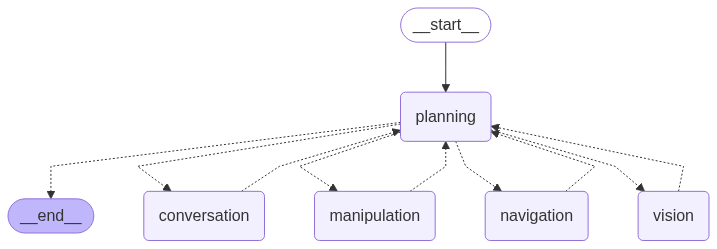

In [48]:
# 6.  BUILD THE GRAPH
# ────────────────────────────────────────────────────────────────

builder = StateGraph(AgentState)

builder.add_node("planning",     planner_node)
builder.add_node("vision",       make_specialist("vision",       VISION_PROMPT, VISION_TOOLS))
builder.add_node("navigation",   make_specialist("navigation",   NAV_PROMPT,    NAVIGATION_TOOLS))
builder.add_node("manipulation", make_specialist("manipulation", MANIP_PROMPT,  MANIPULATION_TOOLS))
builder.add_node("conversation", make_specialist("conversation", CONV_PROMPT,   CONV_TOOLS))

builder.add_edge(START, "planning")  # the single required edge

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
# 7.  QUICK MANUAL TEST
# ────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    user_msg = ("human", "Find the banana.")
    final = graph.invoke({"messages": [user_msg]}, debug=True)
    print(final["messages"])


[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('human', 'Find the banana.')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('human', 'Find the banana.')]
[0:checkpoint] State at the end of step 0:
{'messages': [('human', 'Find the banana.')]}
[1:tasks] Starting 1 task for step 1:
- planning -> AgentState(messages=[('human', 'Find the banana.')],
           plan=[],
           current=None,
           results=[],
           n_executed=0)
llm reply: ```python
[
  {"agent": "vision", "command": "locate the banana", "parallel": false},
  {"agent": "navigation", "command": "navigate to the banana", "parallel": false},
  {"agent": "manipulation", "command": "pick up the banana", "parallel": false},
  {"agent": "conversation", "command": "inform the user that the banana has been found", "parallel": false}
]
```
executing next step: {'agent': 'vision', 'command': 'locate the banana', 'parallel': False}
